# Naive Bayes: Gaussian, Multinomial y Bernulli

## 1. Librerias y configuraciones previas

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Matemáticas y estadísticas
# ==============================================================================
import math


# Preprocesado y modelado
# ==============================================================================
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


#Creación de modelo
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [2]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot, plot_roc_curve

## 3. Carga del dataset

In [3]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('./datasets/02_GermanCredit_Prep.csv')

In [4]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive 
#import os

#drive.mount('/gdrive')

In [5]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [6]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   checking_account_status   1138 non-null   object
 1   loan_duration_mo          1138 non-null   int64 
 2   credit_history            1138 non-null   object
 3   purpose                   1138 non-null   object
 4   loan_amount               1138 non-null   int64 
 5   savings_account_balance   1138 non-null   object
 6   time_employed_yrs         1138 non-null   object
 7   payment_pcnt_income       1138 non-null   int64 
 8   gender_status             1138 non-null   object
 9   other_signators           1138 non-null   object
 10  time_in_residence         1138 non-null   int64 
 11  property                  1138 non-null   object
 12  age_yrs                   1138 non-null   int64 
 13  other_credit_outstanding  1138 non-null   object
 14  home_ownership          

## 4. Visualización de datos

### Variables de entrada

In [7]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

,checking_account_status,credit_history,purpose,savings_account_balance,time_employed_yrs,gender_status,other_signators,property,other_credit_outstanding,home_ownership,job_category,telephone,foreign_worker
0,< 0 DM,critical account - other non-bank loans,car,< 100 DM,1 - 4 years,female-divorced/separated/married,co-applicant,real estate,none,own,skilled,none,yes
1,< 0 DM,current loans paid,car,< 100 DM,1 - 4 years,male-married/widowed,none,real estate,none,own,unskilled-resident,none,yes


In [8]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

d[numCols].head(2)

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents,bad_credit
0,12,3499,3,2,29,2,1,1
1,12,1168,4,3,27,1,1,0


In [9]:
##Visualización de frecuencia de instancias para variables categóricas
#multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [10]:
##Visualización de variables numéricas
#multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [11]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('bad_credit')

### Variable de salida

In [12]:
# Distriución de la variable de salida

d.groupby('bad_credit').bad_credit.count().sort_values(ascending=False)

bad_credit
0    569
1    569
Name: bad_credit, dtype: int64

In [13]:
##Visualización de la variable de salida
#multiple_plot(1, d , None, 'bad_credit', 'countplot', 'Gráfica de frecuencia de bad Credit',0)

## 5. Transformación de datos

### Creación de variables Dummies 

In [14]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d =pd.get_dummies(d, drop_first=1)

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 46 columns):
 #   Column                                                  Non-Null Count  Dtype
---  ------                                                  --------------  -----
 0   loan_duration_mo                                        1138 non-null   int64
 1   loan_amount                                             1138 non-null   int64
 2   payment_pcnt_income                                     1138 non-null   int64
 3   time_in_residence                                       1138 non-null   int64
 4   age_yrs                                                 1138 non-null   int64
 5   number_loans                                            1138 non-null   int64
 6   dependents                                              1138 non-null   int64
 7   bad_credit                                              1138 non-null   int64
 8   checking_account_status_< 0 DM                          11

## 6. Creación del modelo

### Dividir el conjunto de datos

In [15]:
#Se crea una lista con todas las varibles de entrada

vDep = list(d.columns)
vDep.remove('bad_credit')

#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = d.drop(columns ='bad_credit')
y = d['bad_credit']

In [16]:
# Se crean los datasets de entrenamiento y prueba para las variables de entrada y salida 

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 123,
                                        shuffle      = True
                                    )

### Escalar Variables

In [17]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['loan_duration_mo', 'loan_amount', 'payment_pcnt_income', 'time_in_residence', 'age_yrs', 'number_loans', 'dependents']


In [18]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head(2)

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
9,0.0294,0.1319,0.3333,0.3333,0.1667,0.0000,0.0000
798,0.5588,0.5622,0.3333,1.0000,0.4630,0.0000,1.0000


### Creación del modelo

#### Creación y entrenamiento del modelo

Las características de los modelos Naive Bayes son las siguientes:

**GaussianNB**: Este modelo se utiliza cuando las características de entrada se distribuyen de acuerdo con una distribución gaussiana (normal). <u>Es adecuado para variables numéricas continuas</u>.

**MultinomialNB**: Este modelo se utiliza cuando las características de entrada son variables categóricas con recuento discreto. <u>Es adecuado para variables categóricas que representan recuentos o frecuencias</u>.

**BernoulliNB**: Este modelo se utiliza cuando las características de entrada son variables binarias o se pueden binarizar. Es decir, cada característica representa la presencia o ausencia de algo. <u>Es adecuado para variables categóricas binarias o variables que se pueden convertir en binarias</u>. Los valores de características mayores que el umbral se establecen en 1, mientras que los valores iguales o inferiores al umbral se establecen en 0. El umbral se define mediante el parámetro **binarize**, que especifica el valor de corte para la binarización.

In [19]:
#Creación del modelo 

modelGNB       = GaussianNB()
modelBNB       = BernoulliNB(binarize=0.5)
modelMNB       = MultinomialNB()

#Entrenamiento 

modelGNB.fit(X_train, y_train)
modelBNB.fit(X_train, y_train)
modelMNB.fit(X_train, y_train)

MultinomialNB()

### Evaluación del modelo

In [20]:
y_modelGNBT = modelGNB.predict(X_train)
print("modelMNB:",metrics.accuracy_score(y_train, y_modelGNBT))

modelMNB: 0.7175824175824176


In [21]:
# Se realiza la predicción de cada uno de los modelos creados utilizando los datos prueba
y_modelGNB = modelGNB.predict(X_test)
y_modelBNB = modelBNB.predict(X_test)
y_modelMNB = modelMNB.predict(X_test)

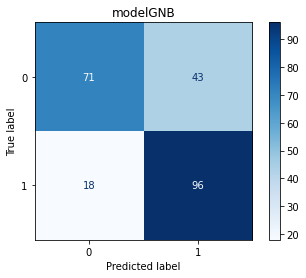

              precision    recall  f1-score   support

           0       0.80      0.62      0.70       114
           1       0.69      0.84      0.76       114

    accuracy                           0.73       228
   macro avg       0.74      0.73      0.73       228
weighted avg       0.74      0.73      0.73       228



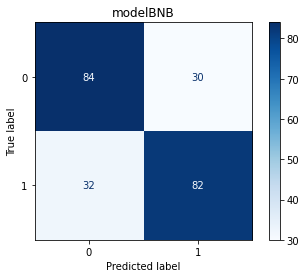

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       114
           1       0.73      0.72      0.73       114

    accuracy                           0.73       228
   macro avg       0.73      0.73      0.73       228
weighted avg       0.73      0.73      0.73       228



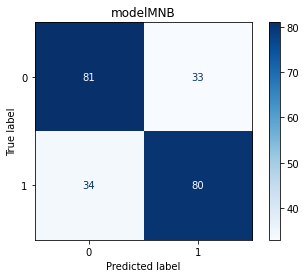

              precision    recall  f1-score   support

           0       0.70      0.71      0.71       114
           1       0.71      0.70      0.70       114

    accuracy                           0.71       228
   macro avg       0.71      0.71      0.71       228
weighted avg       0.71      0.71      0.71       228



In [22]:
# Crear un diccionario de modelos
models = {
    'modelGNB': [modelGNB, y_modelGNB],
    'modelBNB': [modelBNB, y_modelBNB],
    'modelMNB': [modelMNB, y_modelMNB]
}

# Para cada modelo se se extrae un elemento del diccionario models
for model_name, (model, y_pred) in models.items():
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Crear la visualización de la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    
    # Mostrar la visualización
    disp.plot(cmap='Blues')
    
    # Mostrar el título usando matplotlib
    plt.title(model_name)
    
    # Mostrar la figura
    plt.show()

    # Mostrar el informe de clasificación
    print(classification_report(y_test, y_pred))


#### ROC - Receiver Operating Characteristic

0.77: BernoulliNB(binarize=0.5)
0.76: MultinomialNB()
0.75: GaussianNB()


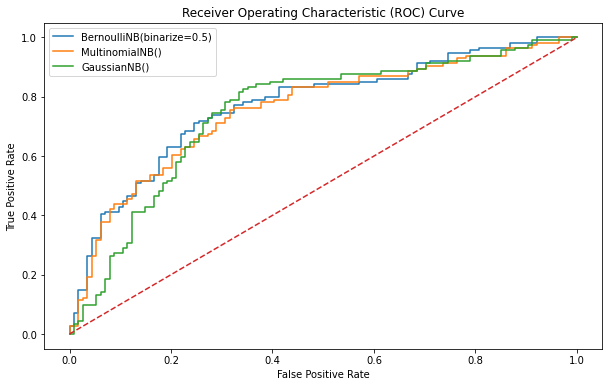

In [23]:
# Crear figura de tamaño 10x6
fig = plt.figure(figsize=(10, 6))  

# Lista de modelos a evaluar
Modelos = [modelBNB, modelMNB, modelGNB]  

# Iterar sobre los modelos
for i in range(len(Modelos)):
    
    # Obtener probabilidades de predicción del modelo
    probs = Modelos[i].predict_proba(X_test)  
    
    # Seleccionar la columna correspondiente a la probabilidad de clase positiva
    probs = probs[:, 1]  

    # Calcular el AUC-ROC
    auc = roc_auc_score(y_test, probs*(1))  

    # Calcular las tasas de FPR y TPR
    fpr, tpr, _ = roc_curve(y_test, probs*(1))  

    # Graficar la curva ROC del modelo actual
    plt.plot(fpr, tpr, label=Modelos[i])  

    # Mostrar el AUC-ROC y el nombre del modelo
    print("{:.2f}: {}".format(auc, Modelos[i]))  


# Graficar la línea diagonal punteada (clasificador aleatorio)
plt.plot([0, 1], [0, 1], linestyle='--')  
plt.xlabel('False Positive Rate')  # Etiqueta del eje x
plt.ylabel('True Positive Rate')  # Etiqueta del eje y
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Título del gráfico
plt.legend()  # Mostrar la leyenda de los modelos
plt.show()  # Mostrar el gráfico


### Guardar modelo

In [24]:
#Se guarda el modelo
joblib.dump(modelBNB, './modelos/clasificacion/NB_Ret_Bernulli.pkl')

['./modelos/clasificacion/NB_Ret_Bernulli.pkl']

### Referencias

- https://www.analyticsvidhya.com/blog/2021/11/implementation-of-gaussian-naive-bayes-in-python-sklearn/

- Multinomial: https://www.youtube.com/watch?v=99MN-rl8jGY&t=90s